# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).There are other packages necessary to import also that sholud be installed.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [8]:
env = UnityEnvironment(file_name="C:/Users/rovaa/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana.exe")

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] Se está cerrando la canalización
Traceback (most recent call last):
  File "C:\Users\rovaa\Anaconda3\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\rovaa\Anaconda3\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "C:\Users\rovaa\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "C:\Users\rovaa\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] Se está cerrando la canalización


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0] # Te devuelve BananaBrain
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces
The simulation contains a single agent that navigates a large environment. At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the following cell, the agent is performing 2 straigth movemenens and 2 left turn movement.

In [66]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0 
n = 20
tramo = 5
for i in range(n): # n steps
    # print(i)
    if i < tramo:
        action = 0       # select walk forward.
    elif tramo <= i< 2*tramo:
        action = 2
    elif 2*tramo<= i< 3*tramo:
        action = 0
    elif 3*tramo<= i< 4*tramo:
        action = 2
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    #print(done)
    score += reward                                # update the score
 
print("Score: {}".format(score)) 

Score: 0.0


In the following cell the agent is performing random actions until the episode finishes.

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action randomly.
    #The randint() method returns an integer number selected element from the specified range. Si solo meto un argumento, es es el valor máximo
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### 4. Train the DQN agent. 
The following dqn function is intended to follow de implementation schema of a DQN agent.

<img src="assets/DQN_algorithm.png" width="40%" align="left" alt="" title="Optimal Policy Equation" />

In [20]:
from agent import Agent
def dqn(n_episodes=200, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
        train_mode = True, ckpt_path='pth_checkpoints/checkpoint.pth',target_stop = True, save_weights= True):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode(bool): if 'True' set environment to training mode
        ckt_path(string): it is the path to set the weights of the trained 
        episode_Stop(bool): if True, the simulation stops when target is reached
        save_weights(bool): if 'True' save weights of the model
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    moving_avgs = [] 
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=train_mode)[brain_name]
        state = env_info.vector_observations[0]  ##env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            action = action.astype(int) # Important acions must be int32 type.
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score of an episode to scores_window, the window for the moving average a deque of 100
        scores.append(score)              # save most recent score of an episode to total scores, total amount of scores
        moving_avg = np.mean(scores_window)  # calculate moving average with the scores window
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        #if i_episode % 10 == 0 and i_episode<100:
        #    print('\r Saving weights at episode {}'.format(i_episode))
        #    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint{}.pth'.format(i_episode))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
            #print('\r Saving weights at episode {}'.format(i_episode))
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint{}.pth'.format(i_episode))
        if target_stop:
            if moving_avg>=13.0:
                # The task is episodic, and in order to solve the environment, 
                # your agent must get an average score of +13 over 100 consecutive episodes. 
                # Eso quiere decir que el agente está entrenado en los i-100 episodios,
                # porque los últimos 100 han sido test para calcular su average score  
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avg))
                if save_weights:
                    torch.save(agent.qnetwork_local.state_dict(), pth_checkpoints)
                break
    return scores, moving_avgs


### 5. Run different tests 

#### 5.1 Standard case with standard values
In this case it is intended to obtain the number of training episodes necessary to get the 13 average score in the last 100 episodes. Weights of the agent trained are also saved.

Episode 100	Average Score: 0.84
Episode 200	Average Score: 3.89


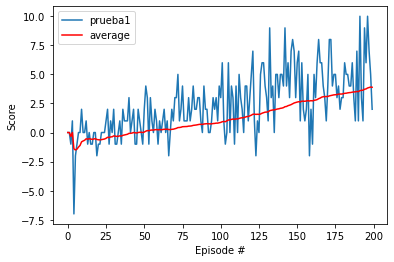

Score: [0.0, 0.0, -1.0, 1.0, -7.0, -2.0, -1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, -2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 2.0, -1.0, 1.0, 0.0, 2.0, -1.0, -1.0, 0.0, 1.0, -1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 2.0, -1.0, -1.0, 2.0, 1.0, 0.0, -1.0, 2.0, 4.0, 3.0, -1.0, 3.0, 1.0, 0.0, 2.0, 1.0, -1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, -2.0, 0.0, 2.0, 1.0, 3.0, 3.0, 5.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 4.0, 2.0, 2.0, 3.0, 3.0, 1.0, 0.0, 4.0, 2.0, 2.0, 0.0, 0.0, 1.0, 3.0, 2.0, 3.0, 1.0, 4.0, 3.0, 6.0, 1.0, -1.0, 0.0, 6.0, 0.0, 4.0, 3.0, -1.0, 4.0, 0.0, 5.0, 3.0, 2.0, 0.0, 4.0, 4.0, 1.0, 3.0, 5.0, 7.0, 1.0, -2.0, 1.0, 0.0, 5.0, 6.0, 6.0, 4.0, 3.0, 1.0, 9.0, 3.0, 4.0, 0.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 9.0, 4.0, 6.0, 3.0, 7.0, 8.0, 7.0, 3.0, 6.0, 7.0, 1.0, 6.0, 2.0, 1.0, 2.0, 5.0, -2.0, 2.0, -1.0, 5.0, 3.0, 6.0, 8.0, 6.0, 6.0, 4.0, 3.0, 1.0, 4.0, 8.0, 8.0, 4.0, 5.0, 5.0, 3.0, 4.0, 2.0, 3.0, 3.0, 6.0, 5.0, 5.0, 4.0, 4.0, 6.0, 3.0, 1.0, 7.0, 1.0, 10.0, 3.0, 1

In [68]:
# Create the agent
agent = Agent(state_size= 37, action_size=4, seed=0, dueling=False, double=False)

# Train the agent
start_time = time.time() # Monitor Training Time  
scores,avgs = dqn(n_episodes=200, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
        train_mode = True, ckpt_path='pth_checkpoints/checkpoint.pth', save_weights = True) # standard values
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Plot the trained agent evolution, considering the scores per episode and de average score

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(np.arange(len(scores)), scores, label='prueba1')
plt.plot(np.arange(len(scores)), avgs_1, color='blue', label='average')
plt.plot(np.arange(len(scores)), avgs_2, color='lightblue', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()
print("Score: {}".format(scores)) # Sacar la secuencia de score de los últimos 100 episodios, sobre los que se hace la media

#### 5.2 Average sensibility to eps_decay for standard case test
In this test it is intended to see the performance evolution of the algorithm in terms of changin the eps_decay, and consecuently going to a transition of exploration to explotation much faster in each of the eps_decays values.

In [21]:
avgs=[]
scores=[]
eps_decay=[0.995, 0.975, 0.955, 0.935, 0.915]
#eps_decay=[0.98 ]
dfs = pd.DataFrame()
dfa = pd.DataFrame()
matrix_scores = []
matrix_avgs = []
start_time = time.time() # Monitor Training Time  
for i, eps in enumerate(eps_decay):
    print('Calculation for eps_dec: ' + str(eps))
    scores,avgs = dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=eps, 
        train_mode = True, ckpt_path='pth_checkpoints/checkpoint.pth', target_stop=False ,save_weights = False)
    matrix_scores.append(scores)
    matrix_avgs.append(avgs)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Calculation for eps_dec: 0.995
Episode 100	Average Score: 0.87
Episode 200	Average Score: 4.71
Episode 300	Average Score: 8.11
Episode 400	Average Score: 10.38
Episode 500	Average Score: 13.48
Episode 513	Average Score: 13.73

KeyboardInterrupt: 

In [63]:
# MAnejar listas de listas
print(matrix_scores)
matrix_np = np.matrix(matrix_scores)
print(matrix_np[0,:])
print(matrix_np[:,0])
print(matrix_avgs[0][0])

[[-1.0, 1.0, 1.0, 0.0, 0.0], [0.0, 1.0, 1.0, 0.0, -1.0]]
[[-1.  1.  1.  0.  0.]]
[[-1.]
 [ 0.]]


Plot results of eps_decay analysis. Como se puede observar con un decay de 0.955 se llega antes al objetivo

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(np.arange(len(scores)), scores, label='prueba1')
for m, eps in zip(matrix_avgs,eps_decay):
    plt.plot(np.arange(len(m)), m, label='eps_dec: ' + str(eps))
plt.ylabel('Moving Average (100 epsiodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()



#### 5.3 Train agent with DDQN and No duelling
In this tests it is intended to get the episode in which the environment is solved, using DDQN technique.

In [ ]:
# Create the agent
agent = Agent(state_size= 37, action_size=4, seed=0, dueling=False, double=True)

#Train agent, stop with avg target and save weights
start_time = time.time() # Monitor Training Time  
scores,avgs = dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.955, 
        train_mode = True, ckpt_path='pth_checkpoints/checkpoint_DDQN.pth',target_stop=True, save_weights = True) # standard values

# plot the scores and the average
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='scores')
plt.plot(np.arange(len(scores)), avgs, color='red', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()
print("Score: {}".format(scores)) # Sacar la secuencia de score de los últimos 100 episodios, sobre los que se hace la media
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Train agent with DDQN and duelling

In [ ]:
# Create the agent
agent = Agent(state_size= 37, action_size=4, seed=0, dueling=True, double=True)

#Train agent, stop with avg target and save weights
start_time = time.time() # Monitor Training Time  
scores,avgs = dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.955, 
        train_mode = True, ckpt_path='pth_checkpoints/checkpoint_DDQN_Duel.pth',target_stop=True, save_weights = True) # standard values

# plot the scores and the average
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='scores')
plt.plot(np.arange(len(scores)), avgs, color='red', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()
print("Score: {}".format(scores)) # Sacar la secuencia de score de los últimos 100 episodios, sobre los que se hace la media
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Cargar los pesos para ver la actuación del agente

In [ ]:
# load the weights from file, different status
from dqn_agent import Agent
agent = Agent(state_size= 37, action_size=4, seed=0)

#agent.qnetwork_local.load_state_dict(torch.load('checkpoint40_GPU.pth', map_location='cpu')) # Si se entrenan con GPU, hay que activar el map_location
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint100.pth'))
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint400.pth'))

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(2):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]  ##env.reset()
    for j in range(200):
        #action = agent.act(state)
        action = agent.act(state)
        action = action.astype(int)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0] 
        #env.render()
        done = env_info.local_done[0]
        #state, reward, done, _ = env.step(action)
        if done:
            break 

When finished, you can close the environment.

In [9]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.